In [1]:
from pickle import load
from glob import glob
import numpy as np

fnames = sorted(glob('*.pkl'))
fnames

['cho_freesolv_fold=0_epoch=250.pkl',
 'cho_freesolv_fold=1_epoch=250.pkl',
 'cho_freesolv_fold=2_epoch=250.pkl',
 'cho_freesolv_fold=3_epoch=250.pkl',
 'cho_freesolv_fold=4_epoch=250.pkl',
 'cho_freesolv_fold=5_epoch=250.pkl',
 'cho_freesolv_fold=6_epoch=250.pkl',
 'cho_freesolv_fold=7_epoch=250.pkl',
 'cho_freesolv_fold=8_epoch=250.pkl',
 'cho_freesolv_fold=9_epoch=250.pkl']

In [2]:
folds = []
for fname in fnames:
    with open(fname, 'rb') as f:
        result = load(f)
    folds.append(result)

In [3]:
result.keys()

dict_keys(['predictions', 'train_inds', 'valid_inds'])

In [4]:
len(result['predictions'])

251

In [5]:
pred_traj = result['predictions']
final_preds = pred_traj[-1]

In [6]:
import pandas as pd
freesolv = pd.read_hdf('freesolv.h5')

In [7]:
freesolv.columns

Index(['SMILES',
       'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)',
       'experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)',
       'Mobley group calculated value (GAFF) (kcal/mol)',
       'calculated uncertainty (kcal/mol)',
       'experimental reference (original or paper this value was taken from)',
       'calculated reference', 'text notes.', 'offmol',
       'serialized_openmm_system'],
      dtype='object')

In [8]:
train_inds = result['train_inds']
valid_inds = result['valid_inds']

In [9]:
expt = freesolv['experimental value (kcal/mol)']
calc = freesolv['Mobley group calculated value (GAFF) (kcal/mol)']

In [10]:
expt[train_inds[0]], calc[train_inds[0]]

(-2.49, -3.3)

In [11]:
final_preds[train_inds[0]]

-2.6486835935144795

In [12]:
def get_pred_vs_ref(pred_dict, inds):
    x = []
    y = []

    for ind in inds:
        x.append(pred_dict[ind])
        y.append(expt[ind])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

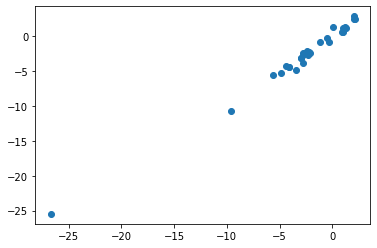

In [13]:
import matplotlib.pyplot as plt

x, y = get_pred_vs_ref(final_preds, valid_inds)
plt.scatter(x, y)

In [14]:
def rmse(x, y):
    return np.sqrt(np.mean((x-y)**2))

In [15]:
rmse(x, y)

0.5706234507520763

In [16]:
train_rmse_traj = []
valid_rmse_traj = []
for pred_t in pred_traj:
    train_rmse_traj.append(rmse(*get_pred_vs_ref(pred_t, train_inds)))
    valid_rmse_traj.append(rmse(*get_pred_vs_ref(pred_t, valid_inds)))

In [18]:
x, y = [], []
for ind in train_inds + valid_inds:
    x.append(calc[ind])
    y.append(expt[ind])
x = np.array(x)
y = np.array(y)

mobley_ref_rmse = rmse(x, y)

(0.0, 4.0)

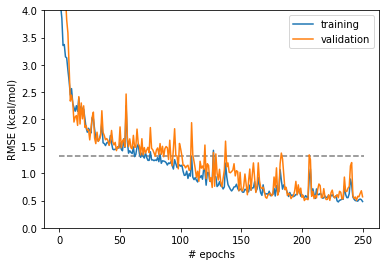

In [19]:
plt.plot(train_rmse_traj, label='training')
plt.plot(valid_rmse_traj, label='validation')

plt.hlines(mobley_ref_rmse, 0, len(train_rmse_traj), linestyle='--', color='grey')
plt.legend()


plt.xlabel('# epochs')
plt.ylabel('RMSE (kcal/mol)')
plt.ylim(0,4)

In [20]:
def get_train_valid_rmse_traj(pred_traj, train_inds, valid_inds):
    train_rmse_traj = []
    valid_rmse_traj = []
    for pred_t in pred_traj:
        train_rmse_traj.append(rmse(*get_pred_vs_ref(pred_t, train_inds)))
        valid_rmse_traj.append(rmse(*get_pred_vs_ref(pred_t, valid_inds)))
    return train_rmse_traj, valid_rmse_traj

In [21]:
train_rmses = []
valid_rmses = []

for fold in folds:
    pred_traj, train_inds, valid_inds = fold['predictions'], fold['train_inds'], fold['valid_inds']
    train_rmse_traj, valid_rmse_traj = get_train_valid_rmse_traj(pred_traj, train_inds, valid_inds)
    train_rmses.append(train_rmse_traj)
    valid_rmses.append(valid_rmse_traj)

train_rmses = np.array(train_rmses)
valid_rmses = np.array(valid_rmses)

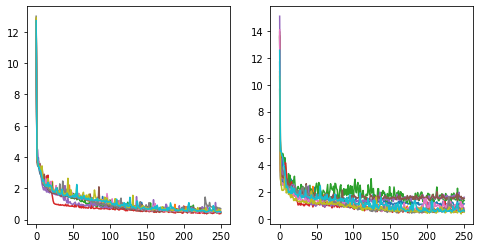

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for i in range(len(train_rmses)):
    plt.plot(train_rmses[i])
    
plt.subplot(1,2,2)
for i in range(len(valid_rmses)):
    plt.plot(valid_rmses[i])

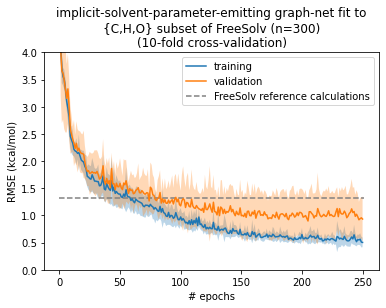

In [23]:
# plot training-set RMSE +/- stddev band
mean = train_rmses.mean(0)
stddev = train_rmses.std(0)

plt.plot(mean, label='training')
plt.fill_between(np.arange(len(mean)), mean - stddev, mean + stddev, alpha=0.3)

# plot validation-set RMSE +/- stdderr band
mean = valid_rmses.mean(0)
stddev = valid_rmses.std(0)
plt.plot(mean, label='validation')
plt.fill_between(np.arange(len(mean)), mean - stddev, mean + stddev, alpha=0.3)

plt.hlines(mobley_ref_rmse, 0, len(train_rmse_traj),
           linestyle='--', color='grey', label='FreeSolv reference calculations')

plt.ylim(0,4)

plt.xlabel('# epochs')
plt.ylabel('RMSE (kcal/mol)')

plt.legend()

plt.title('implicit-solvent-parameter-emitting graph-net fit to\n{C,H,O} subset of FreeSolv (n=300)\n(10-fold cross-validation)')

plt.savefig('kfold_cv_traj.pdf', bbox_inches='tight')

In [24]:
def bootstrap_rmse(sq_residuals, n_bootstrap=1000):
    N = len(sq_residuals)
    
    rmses = [np.sqrt(np.mean(sq_residuals[np.random.randint(0, N, N)])) for _ in range(n_bootstrap)]
    return np.array(rmses)

In [25]:
def report_rmse_pm_95ci(sq_residuals: np.ndarray, n_bootstrap=1000) -> str:
    rmse = np.sqrt(np.mean(sq_residuals))
    rmses = bootstrap_rmse(sq_residuals)
    return f'{rmse:.2f} ' + r'$\pm$' + f' {1.96 * np.std(rmses):.2f}'

In [26]:
lim = min(expt), max(expt)
def plot_train_and_validation(fold, title=''):
    train_inds = fold['train_inds']
    valid_inds = fold['valid_inds']
    final_preds = fold['predictions'][-1]

    ind_dict = {
        'training': train_inds,
        'validation': valid_inds,
    }
    
    ax = None
    for i, name in enumerate(ind_dict):

        x, y = get_pred_vs_ref(final_preds, ind_dict[name])

        rmse_string = report_rmse_pm_95ci((x - y)**2)
    

        ax = plt.subplot(1,2,i+1, sharex=ax, sharey=ax)
        plt.scatter(x, y, alpha=0.8)
        plt.xlabel(r'predicted $\Delta G_{solv}$ (kcal/mol)')
        plt.ylabel(r'experimental $\Delta G_{solv}$ (kcal/mol)')
        plt.plot(lim, lim, color='grey', linestyle='--')

        plt.title(f'GBSA hydration free energies\n{name} set RMSE = {rmse_string} kcal/mol' + title)
    plt.tight_layout()


Plot final training and validation performance for one random split

In [27]:
np.random.seed(0)
fold = np.random.choice(folds)

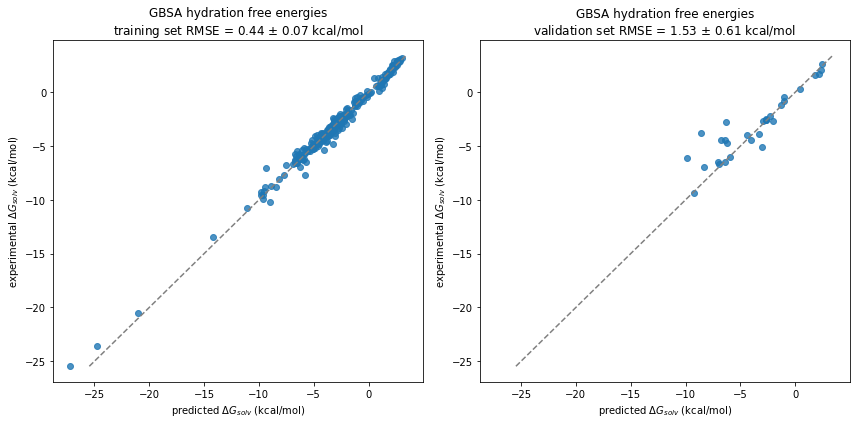

In [28]:
plt.figure(figsize=(12,6))

plot_train_and_validation(fold)

Plot final training and validation performance for each of the 10 random splits

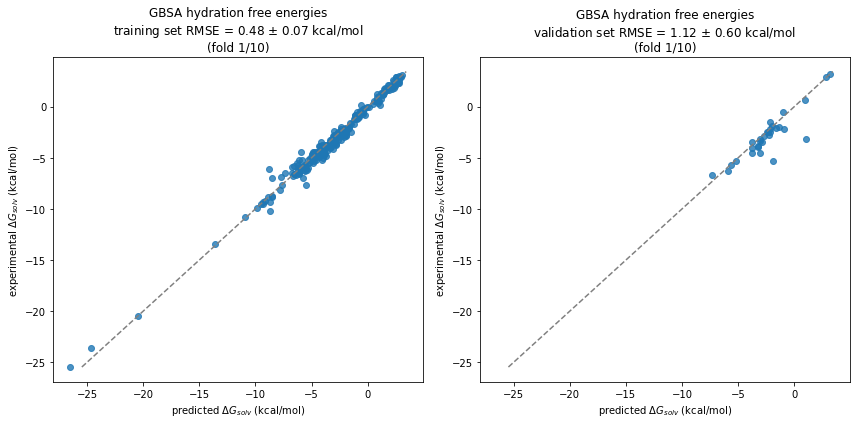

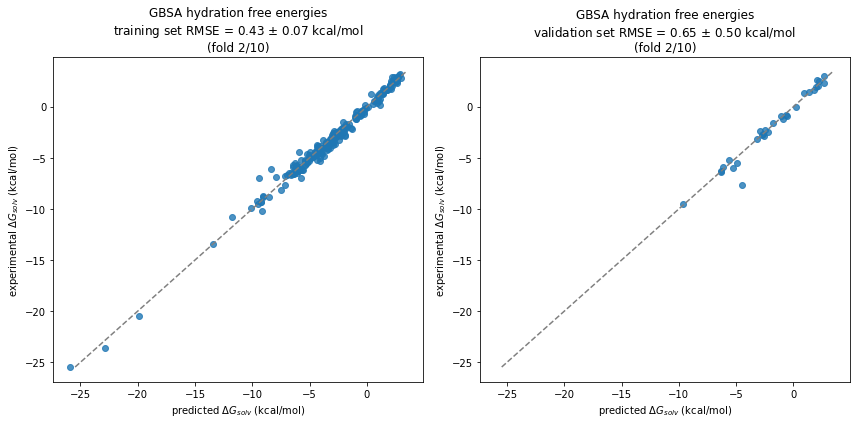

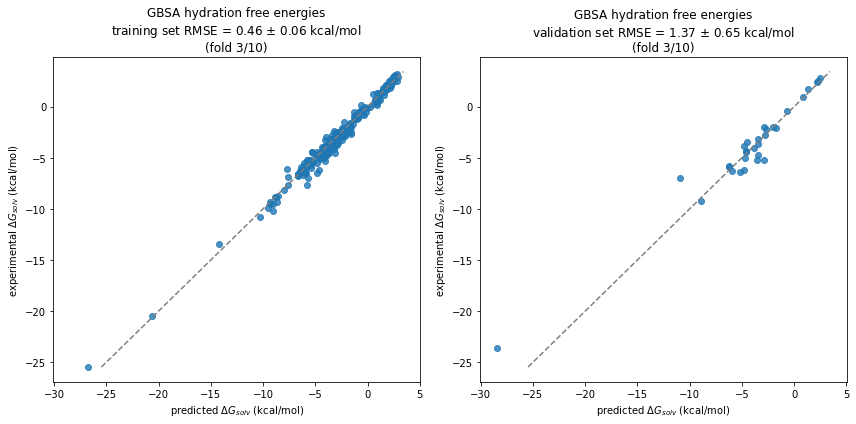

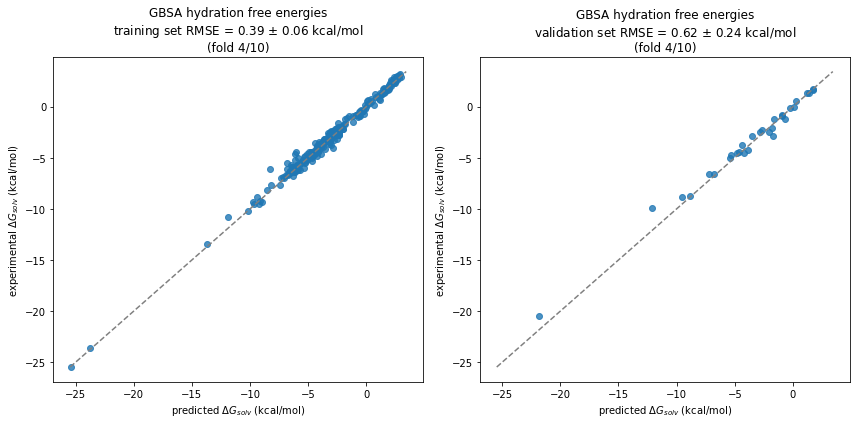

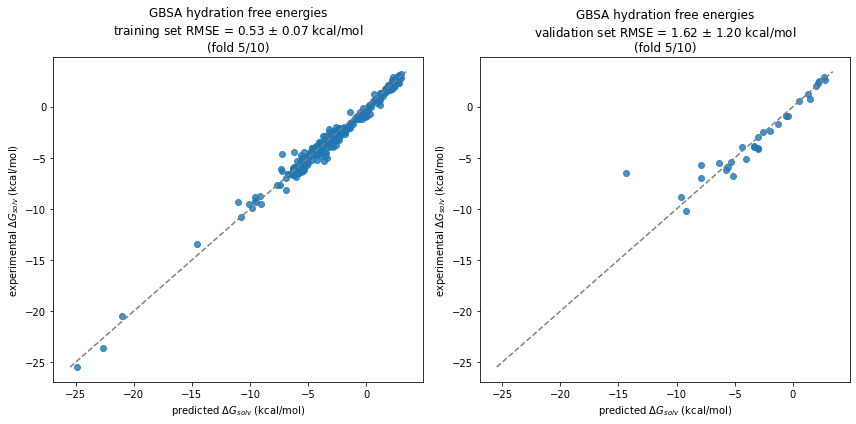

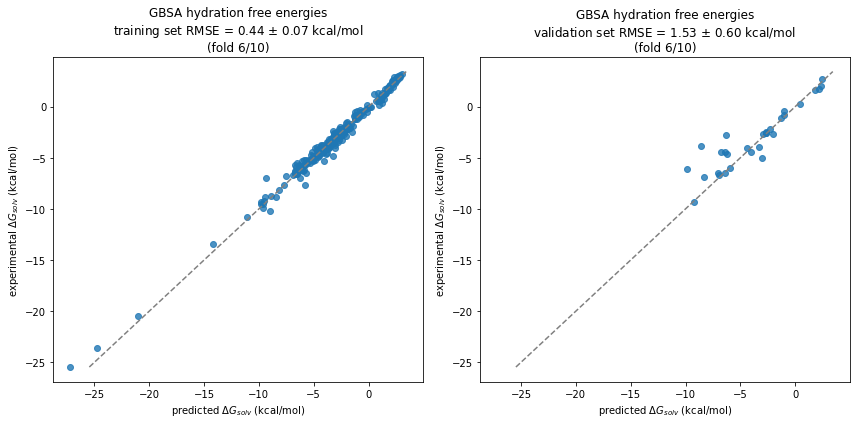

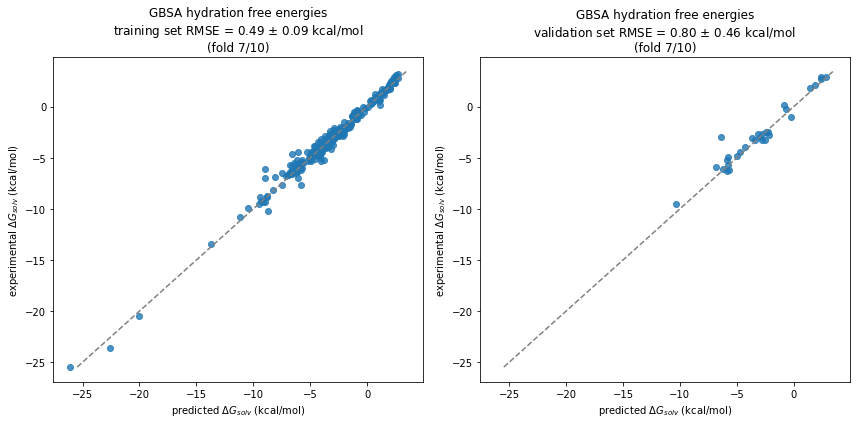

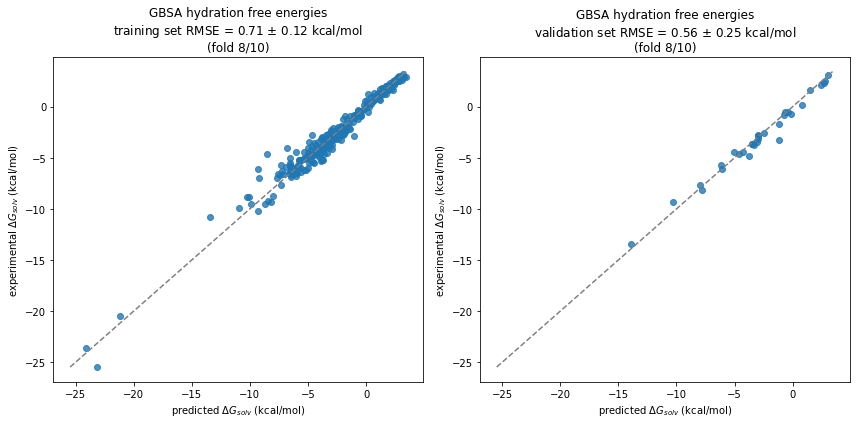

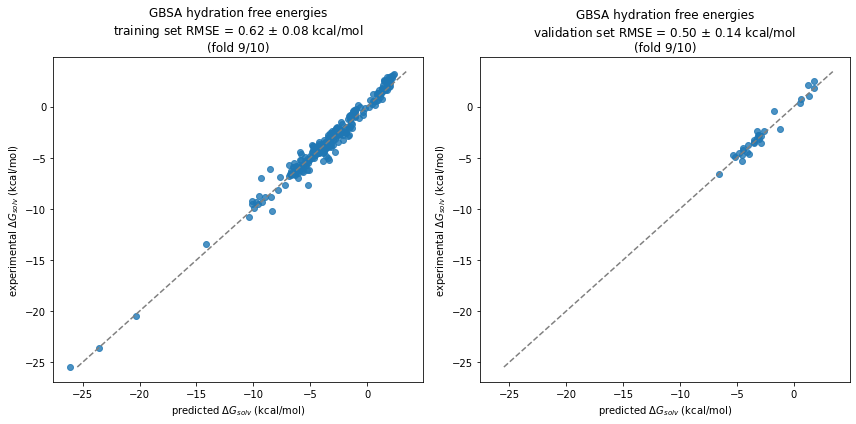

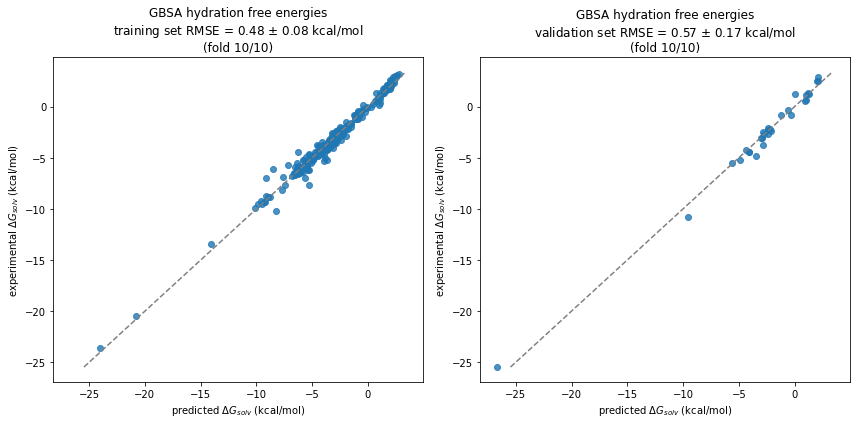

In [29]:
for i, fold in enumerate(folds):
    plt.figure(figsize=(12,6))

    plot_train_and_validation(fold, title=f'\n(fold {i+1}/10)')

TODO: form this into a single PDF figure for inclusion in SI